<a href="https://colab.research.google.com/github/Manuela-AYO/Knn/blob/main/Waveform_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of the KNN algorithm from scratch

On this project, we are going implement KNN algorithm from scratch.

## Libraries

In [1]:
%%capture
!pip uninstall numpy
!pip install numpy == 1.23.1
!pip install gdown seaborn

In [26]:
import gdown
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors
import seaborn as sns
from sklearn.metrics import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D

In [3]:
file_id = "1x94tmcCD-FqQhLXYlrAOKTEr2p4oC9vA"
download_file = "waveform.csv"

In [4]:
gdown.download(id=file_id, output=download_file)

Downloading...
From: https://drive.google.com/uc?id=1x94tmcCD-FqQhLXYlrAOKTEr2p4oC9vA
To: /content/waveform.csv
100%|██████████| 555k/555k [00:00<00:00, 112MB/s]


'waveform.csv'

In [5]:
from numpy import genfromtxt

In [6]:
my_data = genfromtxt(download_file, delimiter=",")

In [7]:
my_data.shape

(5000, 22)

## Data Exploration

In [8]:
np.unique(my_data[:,-1], return_counts=True)

(array([0., 1., 2.]), array([1657, 1647, 1696]))

### Pairplot

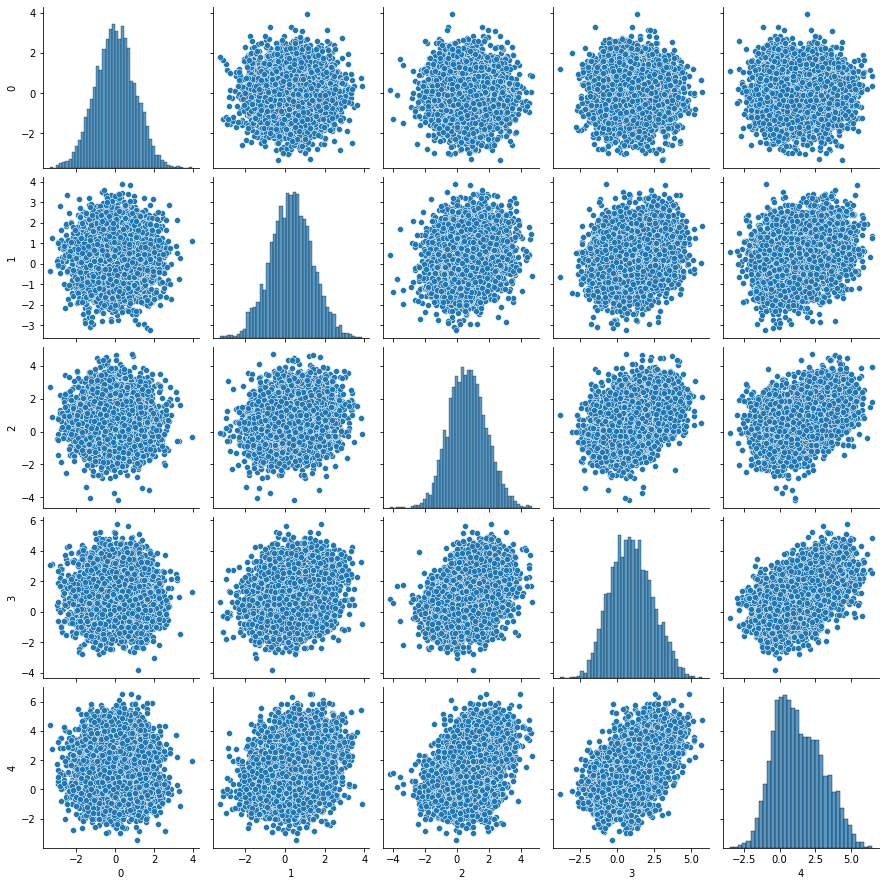

In [ ]:
subset = pd.DataFrame(my_data[:, :5])
sns.pairplot(subset)

Comments : We can see that the first columns 3, 4 and 2 are correlated

### Visualization of the 2 first columns

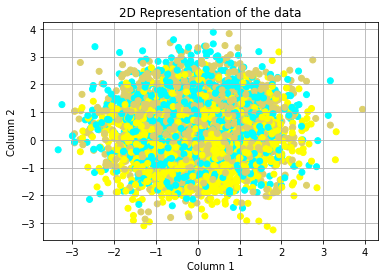

In [ ]:
color = colors.ListedColormap(["#00FFFF", "#DDD06A", "yellow"])
plt.scatter(my_data[:,0], my_data[:,1], c=my_data[:,-1], cmap=color)
plt.title("2D Representation of the data")
plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.grid()
plt.show()

## Data Splitting

### Configuration

In [92]:
train_size = 4000
test_size = 1000

### Randomly splitting 4000 samples as a training set, and keep other 1,000 as a test set

In [93]:
def train_test_split(my_data : np.array, train_size : int) -> tuple([np.array, np.array, np.array, np.array]):
  """
  Randomly split data into train and test set
  """
  # set the seed
  np.random.seed(2)

  # indices of data
  total_idx = np.arange(len(my_data))

  # randomly draw the indices of train set 
  train_idx = np.random.choice(total_idx, train_size, replace=False)

  # keep other indices as the indices of test set
  test_idx = total_idx[np.isin(total_idx, train_idx, invert=True)] 

  # retrieve the corresponding data of training and test sets
  X_train = my_data[train_idx, :-1].copy()
  y_train = my_data[train_idx, -1].copy()
  y_train = y_train.reshape(-1,1)
  X_test = my_data[test_idx, :-1].copy()
  y_test = my_data[test_idx, -1].copy()
  y_test = y_test.reshape(-1,1)

  return X_train, y_train, X_test, y_test

In [94]:
# select the corresponding data of the indices
X_train, y_train, X_test, y_test = train_test_split(my_data, train_size)
y_train = y_train.astype(int)
y_test = y_test.astype(int)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 21)
(4000, 1)
(1000, 21)
(1000, 1)


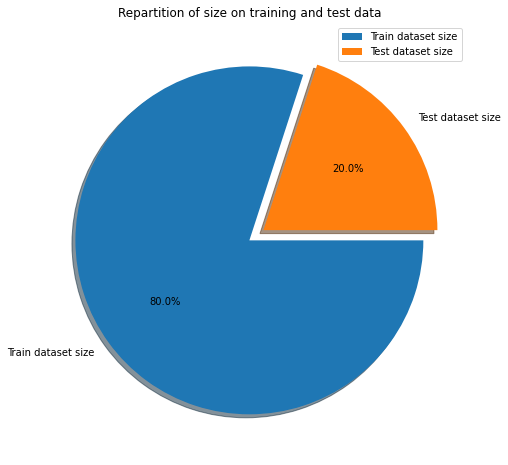

In [95]:
plt.figure(figsize=(16,8))
plt.pie(x=[train_size, test_size], labels=["Train dataset size", "Test dataset size"], 
        explode=[0, 0.1], counterclock=False, shadow=True, autopct='%1.1f%%')
plt.title("Repartition of size on training and test data")
plt.legend(loc="upper right")
plt.show()

## KNN Classifier

In [12]:
class Node:
    """
      Description:
      The class stores a binary tree. The node at the top of the tree is the root. 
      The root node has at most two children on the left and the right. Those children can be a subtree.

      Args:


      References:
      1. Constructing the binary tree in Python: https://www.tutorialspoint.com/python_data_structure/python_binary_tree.htm
      2. Constructing and searching KD-Tree: https://en.wikipedia.org/wiki/K-d_tree
    """
    def __init__(self, root: np.array, left, right, axis: int) -> None:
        self.root = root
        self.left = left
        self.right = right
        self.axis = axis

    def display(self):
      print(self.root)
      print("Left")
      if self.left is not None:
        self.left.display()
      print("Right")
      if self.right is not None:
        self.right.display()

In [13]:
class BadValueKError(Exception):
    """_summary_
        Is raised when k <= 0, k being the number of k neigbors
    Args:
        Exception (_type_): _description_
    """
    pass

In [14]:
class knnClassifier:
    """_summary_
       knn Classifier : class used to apply the k nearest neighbors
       Initialization Parameters :
            k : number of neighbors. Default is 1
            algorithm : algorithm used to find the nearest neighbors.
                Could be the default one, the kd-tree or the speed-up algorithm
            metric : distance metric used 
    """
    
    def __init__(self, k:int = 1, algorithm:str = "default", metric:str = "euclidian_distance", opt:bool=False) -> None:
        try:
            if k <= 0:
                raise BadValueKError
            self.k = k
            self.algorithm = algorithm
            self.metric = metric
            self.feature_vector = None
            self.target_vector = None
            self.distances_table = None
            self.pair_wise_distances = None
            self.tree = None
            self.opt = opt

        except BadValueKError as e:
            print("BadValueKError : the number of neighbors k should be at least greater than 1")
        
    def __str__(self) -> str:
        output = f"KNN Classifier : \n\tn_neighbors : {self.k}\n\talgorithm : {self.algorithm}\n\tmetric : {self.metric}"
        if (self.feature_vector is not None) and (self.target_vector is not None):
            output += f"\n\tfeature vector's shape : {self.feature_vector.shape}\n\ttarget vector's shape : {self.target_vector.shape}"
        return output

    # update the value of k
    def update_k(self, new_value_k : int) -> None:
      self.k = new_value_k

    # compute the pairwise distances between points of the feature vector
    def compute_pairwise_distances(self) -> None :
      assert (self.feature_vector is not None)
      self.pair_wise_distances = pairwise_distances(self.feature_vector)
    
    # fit the data to the knnClassifier
    def fit(self, X: np.array, y:np.array) -> None:
        self.feature_vector = X
        self.target_vector = y

    # compute the manhattan distance between a point and a set of points
    # and return the sorted indexes
    def manhattan_distance(self, point : np.array, X : np.array) -> np.array :
      # table that stores the distances
      if self.opt : 
        distance_table = np.sum(np.abs(X-point), axis=1)
      
      else : 
        distance_table = np.zeros(len(self.feature_vector))
        for i in range(len(X)) :
          p = X[i].reshape(-1, 1)
          distance_table[i] = np.sum(np.abs(p-point))

      # sort the indexes
      sorted_idx = np.argsort(distance_table, axis=0)

      return sorted_idx
        
    # compute the euclidian distance between a point and a set of points
    # and return the sorted indexes
    def euclidian_distance(self, point : np.array, X : np.array) -> np.array :
        # table that stores the distances
        if self.opt :
          distance_table = np.sqrt(np.sum((X-point)**2, axis=1))

        else : 
          distance_table = np.zeros(len(self.feature_vector))
          for i in range(len(X)) :
            p = X[i].reshape(-1, 1)
            distance_table[i] = np.sqrt(np.sum((p-point)**2))

        # sort the table
        sorted_idx = np.argsort(distance_table, axis=0)
        
        return sorted_idx
    
    # apply a specific metric for knn distance computation
    def apply_metric(self, point:np.array) -> None:
        try :
            assert (self.feature_vector is not None)
            
            if self.metric == "euclidian_distance":
                self.distances_table = self.euclidian_distance(point, self.feature_vector)

            elif self.metric == "manhattan_distance":
              self.distances_table = self.manhattan_distance(point, self.feature_vector)
            
        except AssertionError as e:
            e.args += ("You should fit the feature vector to the classifier",)
            raise
       
    # return a list containing tuple of (index,distance) where 
    # distance is the distance to the nearest neighbors and
    # index the actual index of the point in the dataframe
    def get_neighbors(self, point : np.array) -> np.array:
        return self.distances_table[:self.k]
    
    # return the label of a given point
    def get_label(self, point : np.array) -> int:
        if self.algorithm == "kd_tree":
          if self.tree is None : 
            self.tree = self.construct_tree(self.feature_vector)
          return self.search(self.tree, point)
        
        if self.algorithm == "sphere":
          return self.sphere_oriented_speedup(point)

        # get the neighbors
        neighbors = self.get_neighbors(point) ###################
        
        # apply the majority vote
        neighbors_labels = self.target_vector[neighbors].reshape(-1)
        neighbors_labels = neighbors_labels.astype("int")
        
        if self.k == 1:
            return neighbors_labels

        # The aim here is to add more randomness in the choice of a class 
        # when at least 2 classes have the same occurence
        # That's the reason why we don't use np.argmax()
        
        # count the occurence of each class
        counts = np.bincount(neighbors_labels)

        # nb_max will contain the indice(s) of the majority class(es)
        nb_max = np.where(counts == np.amax(counts))[0]

        # if there is only one majority class, return it
        if len(nb_max) == 1:
          return nb_max[0]

        # otherwise, random guess
        guess = np.random.randint(0, len(nb_max))
        return nb_max[guess]
    
    # accuracy of the prediction : 
    def score(self, X:np.array, y:np.array, k_values:int = 1) -> np.array:
      """
        __summary__ : 
        This function computes the score for a range of values of k

        Args :
        X(pd.DataFrame) : Set of points for which we need to predict the
        label
        y(pd.Series) : Label of those points
        k_values(int) : range of values of k for knn. 
          If k=1, get the label according to 1NN rule
          Else, get the label from 1 to k_values NN rule

        Returns : 
          An array of score. 
          If k=1, return a 1*1 array containing 1 score(1NN prediction)
          Else return a 1*k_values+1 array containing the scores from
            k=1 to k_values nearest neighbors
      """
      # k_scores values
      k_scores = np.zeros(k_values+1)

      # for each point
      for i in range(len(y)):
        # compute the table of distances
        self.apply_metric(X[i])

        # compute the knn scores
        for k in range(1, k_values+1):
          self.update_k(k)
          pred_label = self.get_label(X[i]) ##################
          if y[i] == pred_label:
            k_scores[k] += 1

      k_scores /= len(y)
      return k_scores


    # sphere oriented speed-up
    def sphere_oriented_speedup(self, point : np.array) -> int:
      """
        __summary__:
        This function returns the label of a point using the 1NN rule 
        and the speed-up method based on the sphere radius

        Args :
          point (np.array) : nb_features * 1 array representing a point

        Returns :
          Return the label of the point
      """

      # compute the table of pairwise distances if it's not yet done
      if self.pair_wise_distances is None:
        self.compute_pairwise_distances()

      # get the list of indexes
      l = np.arange(len(self.feature_vector))

      # consider the first point as knn
      nn = 0
      p = self.feature_vector[0].reshape(-1, 1)

      # distance between p and point
      dmin = np.sqrt(np.sum((point-p)**2))

      # remove that point from the list => we explored the point
      l = np.delete(l, 0)

      # continue the exploration
      while len(l) != 0:
        # explore the next point
        next = l[0]
        l = np.delete(l, 0)

        # remove points that can't be nn
        p1 = self.feature_vector[next].reshape(-1, 1)

        # distance between p1 and point
        d = np.sqrt(np.sum((point-p1)**2))

        if d >= dmin :
          # remove points in the circle center in point next
          indexes1 = np.where(self.pair_wise_distances[next] < d-dmin)[0]
        
          # remove points that are too far from i
          indexes2 = np.where(self.pair_wise_distances[next] > d+dmin)[0]

        else :
          temp = d
          d = dmin
          dmin = temp

          # do the operation in the "if" statement for point nn
          indexes1 = np.where(self.pair_wise_distances[nn] < d-dmin)[0]
          indexes2 = np.where(self.pair_wise_distances[nn] > d+dmin)[0]

          # store the new 1nn
          nn = next

        indexes = np.concatenate((indexes1, indexes2))

        l = l[np.isin(l, indexes, invert=True)]

      # return the label
      return self.target_vector[nn]

    # KD-Tree Construction
    def construct_tree(self, X:np.array, depth:int=0) -> Node:
        """
          Construct the kd-tree of an array

          Args :
            X(np.array) : array to construct the tree
            depth(int) : depth of the tree

          Return :
            Node : the kd-tree
        """

        if len(X) == 0:
          return None
          
        dimension = len(X)
        # get the axis of comparison
        axis = depth % dimension

        # sort the values on that axis
        temp = np.argsort(X[:, axis])
        
        # construct the tree
        median_idx = len(temp)//2
        idx = temp[median_idx]
        
        root = X[idx].reshape(-1,1)
        left = X[temp[:median_idx]].copy()
        right = X[temp[median_idx+1:]].copy()

        return Node(root, self.construct_tree(left, depth+1), self.construct_tree(right, depth+1), axis=axis)


    def search_deep(self, tree: Node, point: np.array, current_best: Node, best_distance: float) -> tuple([Node, float]):
      """
        Look for the nearest neighbor using the kd-tree

        Args :
          tree(Node) : kd-tree to explore
          point(np.array) : point for which we're looking for the neighbor
          current_best(np.array) : current nearest neighbor
          best_distance(float) : distance between point and the nearest neighbor

        Return :
          tuple([Node, float]) : nearest neighbor and distance to the point
      """
    
      if tree is None:
        return current_best, best_distance

      axis = tree.axis

      if point[axis] <= tree.root[axis] :
        closer_side = tree.left
        other_side = tree.right

        # get the point on the left
        if tree.left != None : 
          p_left = tree.left.root
          d_left = np.sqrt(np.sum((point-p_left)**2))

          if d_left < best_distance :
            best_distance = d_left
            current_best = tree.left.root.copy()

      else :
        closer_side = tree.right
        other_side = tree.left

        # get the point on the right
        if tree.right != None : 
          p_right = tree.right.root
          d_right = np.sqrt(np.sum((point-p_right)**2)) 

          if d_right < best_distance :
            best_distance = d_right
            current_best = tree.right.root.copy()
        
      current_best, best_distance = self.search_deep(closer_side, point, current_best, best_distance)

      # is it worthy to execute the other side ?
      if np.absolute(point[axis] - tree.root[axis]) < best_distance:
        current_best, best_distance = self.search_deep(other_side, point, current_best, best_distance)

      return current_best, best_distance


    def search(self, tree:Node, point:np.array):
      # consider the root point of the tree as neighbor
      neighbor = tree.root.copy()

      # distance to that point
      best_distance = np.sqrt(np.sum((point-neighbor)**2))

      # get the nearest neighbor
      neighbor, distance = self.search_deep(tree, point, neighbor, best_distance)

      # return its label
      index = (self.feature_vector == neighbor.reshape(1,-1)[0]).all(axis=1).nonzero()
      idx = int(index[0])
  
      return self.target_vector[idx]

## Euclidian or Manhattan distance ?

On this section, the aim is to tune the value of k and to also compare the 02 metrics(manhattan and euclidian distance).

For this purpose, we'll tune k using manhattan and euclidian distance. 

The best metric will be the one which, given its optimal value of k, will have the best accuracy.

### Tune of k

#### cross-validation

In [96]:
def cross_validation_split(X : np.array, y : np.array, num_folds : int, classifier : knnClassifier, k_values : int) -> np.array:
  """
  Split train set into n folds
  X: Array of features of the train set
  y: Array of target of the train set
  num_folds : number of folds to split the data
  classifier : knnClassifier we apply
  k_values : The range of values of k for analyzing the score

  Returns : the cross validation score
  """
  # create the 2D array of scores
  folds_scores = np.zeros((num_folds, k_values+1))

  # number of points on each fold
  fold_size = int(len(X)/num_folds) # floor

  # begining index
  start = 0

  for i in range(num_folds):
    stop = start + fold_size

    # retrieve validation set
    X_val = X[start:stop]
    y_val = y[start:stop]

    # training set
    if stop < len(X):
        X_train = np.vstack((X[:start], X[stop:]))
        y_train = np.vstack((y[:start], y[stop:]))
    else:
        X_train = X[:start].copy()
        y_train = y[:start].copy()

    # fit the training set to the classifier
    classifier.fit(X_train, y_train)

    # get the scores for the fold i
    folds_scores[i] = classifier.score(X_val, y_val, k_values)

    # update the begining index
    start += fold_size
     
  return folds_scores

#### Running of the tuning of k using euclidian distance

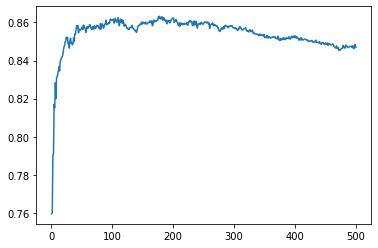

In [ ]:
# let us take a look on the impact of k over the accuracy
clf = knnClassifier(opt = True)

# theoretical optimal value for k
optimal_n = int(np.sqrt(len(X_train)/3))
max_n = 500

# mean cross-validation error over k
mean_cv_k = np.zeros(max_n+1)

# perform cross-validation
validation_scores = cross_validation_split(X_train, y_train, 10, clf, max_n)
for i in range(1,max_n+1):
  mean_cv_k[i] = np.mean(validation_scores[:,i])
    
# plot the observation
plt.plot(np.array(np.arange(1,len(mean_cv_k))), mean_cv_k[1:])

#### Best value of k and its accuracy using the euclidian distance

In [ ]:
k = np.argmax(mean_cv_k)
print(k)
print(mean_cv_k[k])
print(mean_cv_k[63])
print(mean_cv_k[64])

178
0.8632500000000001
0.85875
0.85875


Comments : Theoretically, the best value of k should be 64($\sqrt(4000)$ where 4000 is the length of X_train.\

But in practic, the best value of k is 178 

#### Running of the tuning of k using manhattan distance

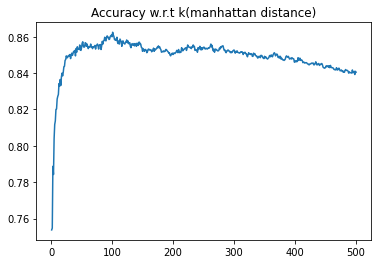

In [ ]:
# let us take a look on the impact of k over the accuracy
clf = knnClassifier(metric = "manhattan_distance", opt = True)

# theoretical optimal value for k
optimal_n = int(np.sqrt(len(X_train)/3))
max_n = 500

# mean cross-validation error over k
mean_cv_k = np.zeros(max_n+1)

# perform cross-validation
validation_scores = cross_validation_split(X_train, y_train, 10, clf, max_n)
for i in range(1,max_n+1):
  mean_cv_k[i] = np.mean(validation_scores[:,i])
    
# plot the observation
plt.plot(np.array(np.arange(1,len(mean_cv_k))), mean_cv_k[1:])
plt.title("Accuracy w.r.t k(manhattan distance)")
plt.show()

#### Best value of k

In [ ]:
k = np.argmax(mean_cv_k)
print(k)
print(mean_cv_k[k])

101
0.8625


The accuracy using the euclidian distance better is better than the accuracy using the manhattan distance.

That's probably the reason why we prefer euclidian distance

## Reduce the time complexity

### Data Cleaning : remove the outliers and the points in the Bayesian region

In [38]:
def remove_mis(knn:knnClassifier, X:np.array, y:np.array) -> tuple([np.array, np.array, int]):
  """
    apply 1NN-rule over X and remove the misclassified points
  """
  indexes_dustbin = []

  # collect the indexes of the misclassified points
  for i in range(len(X)):
      point = X[i].reshape(1, -1)
      knn.apply_metric(point)
      predict = knn.get_label(point)
      if y[i] != predict: # is it misclassified ?
          indexes_dustbin.append(i)

  # remove all the misclassified points
  X,y = np.delete(X, indexes_dustbin, axis=0), np.delete(y, indexes_dustbin, axis=0)

  return X, y, len(indexes_dustbin)

In [39]:
# main function to process data cleaning
def clean(X:np.array, y:np.array) -> tuple([np.array, np.array]):
    
    # split of the data
    np.random.seed(2)
    total_idx = np.arange(len(X))
    index_one = np.random.choice(total_idx, len(total_idx)//2, replace=False)
    index_two = total_idx[np.isin(total_idx, index_one, invert=True)]
    X1 = X[index_one].copy()
    y1 = y[index_one].copy()

    X2 = X[index_two].copy()
    y2 = y[index_two].copy()
    
    # cleaning
    error = -1
    knn = knnClassifier(opt = True)
    
    while error != 0 :
        error = 0
        # remove outliers and bayesian region points from X1
        knn.fit(X2,y2)
        X1, y1, error_cmp = remove_mis(knn, X1, y1)
        error += error_cmp
        if len(X1) == 0:
          break
        # remove outliers and bayesian region points from X2
        knn.fit(X1,y1)
        X2, y2, error_cmp = remove_mis(knn, X2, y2)
        error += error_cmp
        if len(X2) == 0:
          error = 0

    return np.vstack((X1,X2)), np.vstack((y1,y2))
    

### Data Condensation

In [40]:
def data_condensation(X: np.array, y: np.array, clf: knnClassifier) -> tuple([np.array, np.array]): 
  """
  __summary__ :
  Another function for reducing the complexity of KNN. Determining. It takes the data without outliers and the bayes region. 
  The goal is to filter essential points for building the classifier.
  
  Args :
  X: np.array
  y: np.array
  clf: A knnClassifier
  """

  # the storage contains essential points (reduced points)
  np.random.seed(2)
  rand_idx = np.random.randint(0, len(X))
  
  # randomly put a training sample (a reference) into a storage
  storage_X = X[rand_idx].reshape(1,-1)
  storage_y = y[rand_idx].reshape(1,-1)
  
  # initialize the storage size and current storage
  current_storage_size = len(storage_X)
  previous_storage_size = -1

  # drop the sample as it is a reference
  X = np.delete(X, rand_idx, axis=0)
  y = np.delete(y, rand_idx, axis=0)

  while(previous_storage_size != current_storage_size): # loop through the remaining training samples (dustbin)
    previous_storage_size = current_storage_size
    # dustbin indexes
    indexes = []

    for i in range(len(X)): # pass through original training set
      # classify a training sample with the storage
      clf.fit(storage_X, storage_y)
      t = X[i].reshape(1,-1)
      clf.apply_metric(t)
      pred = clf.get_label(t)
      if y[i] != pred: # if not correctly classified
        storage_X = np.vstack((storage_X, t))
        storage_y = np.vstack((storage_y, y[i]))
        indexes.append(i)
    
    current_storage_size = len(storage_X)
    
    X = np.delete(X, indexes, axis=0)
    y = np.delete(y, indexes, axis=0)
  
  return storage_X, storage_y

### Accuracy before data reduction over the 1000 test waves

In [54]:
knn = knnClassifier(opt = True)
knn.fit(X_train, y_train)

In [55]:
accuracy_bf_dr = knn.score(X_test, y_test)[1]

In [56]:
print(accuracy_bf_dr)

0.784


### Accuracy after data reduction on the 1000 test waves

In [57]:
clf = knnClassifier(opt = True)

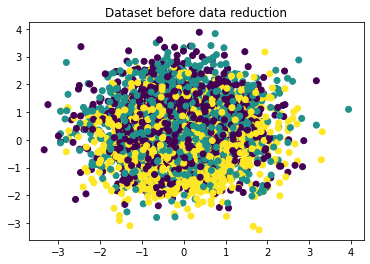

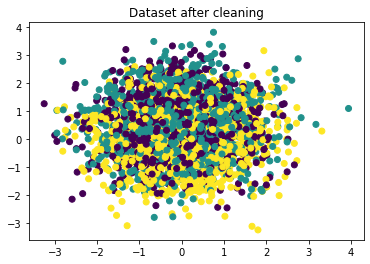

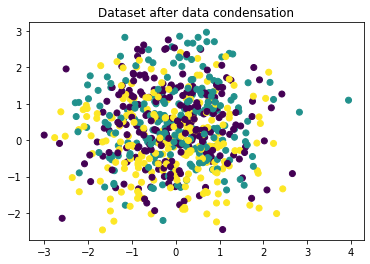

In [58]:
plt.scatter(X_train[:, 0], X_train[:,1], c=y_train)
plt.title("Dataset before data reduction")
plt.show()

# data cleaning
new_x_train, new_y_train = clean(X_train, y_train)

plt.scatter(new_x_train[:, 0], new_x_train[:,1], c=new_y_train)
plt.title("Dataset after cleaning")
plt.show()

# data condensation
solution = data_condensation(new_x_train, new_y_train, clf)
x_cond = solution[0].copy()
y_cond = solution[1].copy()

plt.scatter(x_cond[:, 0], x_cond[:,1], c=y_cond)
plt.title("Dataset after data condensation")
plt.show()

# fit the data to the classifier
clf.fit(x_cond, y_cond)

# compute the accuracy
accuracy_af_dr = clf.score(X_test,y_test)

In [59]:
print(f"Accuracy after data reduction : {accuracy_af_dr[1]}\n")

Accuracy after data reduction : 0.757



In [60]:
# test accuracy with the first step reduction only
# fit the data to the classifier
clf.fit(new_x_train, new_y_train)

# compute the accuracy
accuracy_af_dc = clf.score(X_test,y_test)

In [61]:
print(f"Accuracy after data cleaning : {accuracy_af_dc[1]}\n")

Accuracy after data cleaning : 0.794



### Comparison of the accuracies

In [ ]:
print(f"Accuracy before data reduction : {accuracy_bf_dr}\n")
print(f"Accuracy after data reduction : {accuracy_af_dr[1]}\n")
print(f"Accuracy after first step data cleaning : {accuracy_af_dc[1]}\n")

Accuracy before data reduction : 0.776

Accuracy after data reduction : 0.754

Accuracy after first step data cleaning : 0.799



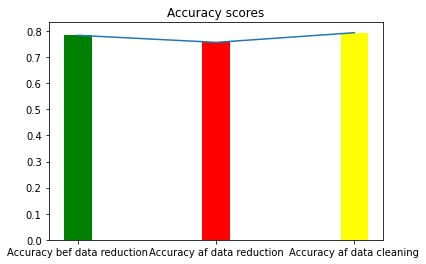

In [70]:
labs = ["Accuracy bef data reduction", "Accuracy af data reduction", "Accuracy af data cleaning"]
color = ["green", "red", "yellow"]
plt.bar(x=[1,5,9], height=[accuracy_bf_dr, accuracy_af_dr[1], accuracy_af_dc[1]],
        align="center", color=color, tick_label=labs
        )
plt.plot([1,5,9], [accuracy_bf_dr, accuracy_af_dr[1], accuracy_af_dc[1]])
plt.title("Accuracy scores")
plt.show()

**Comments** : We observe that the accuracy after data reduction is less than the accuracy before data reduction.

This could be explained by the fact that data condensation may remove some important points as the choice of the reference point is random in condensed nearest neighbor.

This hypothesis comes from the fact that when we just remove outliers and bayesian region points, the accuracy is greater than the accuracy before data reduction.

## Speed-up

### Time Comparison

Running time of brute force algorithm

In [ ]:
%%timeit -r 1 -n 1
clf = knnClassifier()
clf.fit(X_train, y_train)
for i in range(test_size):
  point = X_test[i].reshape(1, -1)
  clf.apply_metric(point)
  label = clf.get_label(point)

54.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Running time of sphere-oriented speed-up

In [ ]:
%%timeit -r 1 -n 1
clf = knnClassifier(algorithm = "sphere")
clf.fit(X_train, y_train)
for i in range(test_size):
  point = X_test[i].reshape(1, -1)
  label = clf.get_label(point)

5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Running time of kd-tree

In [ ]:
%%timeit -r 1 -n 1
clf = knnClassifier(algorithm = "kd_tree")
clf.fit(X_train, y_train)
for i in range(test_size):
  point = X_test[i].reshape(1, -1)[0]
  label = clf.get_label(point)

Treeee is donnnnnnne !!!!
56.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Imbalancy Dataset

### Generate Imbalancy

In [97]:
nb_imbalance = 100

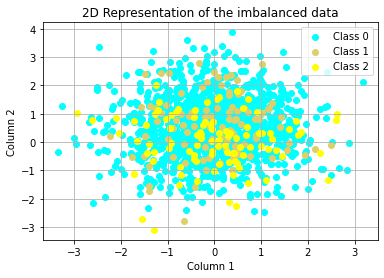

In [87]:
# generate imbalancy dataset
# the majority class is class 0 
# we take all the points of class 0
# 100 points of class 1 and 100 points of class 2

# splitting
class0 = np.where(y_train == 0)[0]
class1 = np.where(y_train == 1)[0]
class2 = np.where(y_train == 2)[0]

arr_class1 = np.random.choice(class1, nb_imbalance, replace=False)
x_class1 = X_train[arr_class1].copy()
y_class1 = y_train[arr_class1].copy()

arr_class2 = np.random.choice(class2, nb_imbalance, replace=False)
x_class2 = X_train[arr_class2].copy()
y_class2 = y_train[arr_class2].copy()

x_class0 = X_train[class0].copy()
y_class0 = y_train[class0].copy()

# generate the new array
new_X = np.vstack((x_class0, x_class1, x_class2))
new_Y = np.vstack((y_class0, y_class1, y_class2))

color = ["#00FFFF", "#DDD06A", "yellow"]
labels = ["Class 0", "Class 1", "Class 2"]
for i in [0,1,2]:
  indexes = np.where(new_Y == i)[0]
  plt.scatter(new_X[indexes,0], new_X[indexes,1], c=color[i], label=labels[i])
plt.title("2D Representation of the imbalanced data")
plt.xlabel("Column 1")
plt.ylabel("Column 2")
plt.grid()
plt.legend(loc="upper right")
plt.show()

### Tune k w.r.t F-measure

In [88]:
clf = knnClassifier(opt=True)
clf.fit(new_X, new_Y)
nb_k = 100

f_measure = np.zeros(nb_k+1)
accuracy_tab = np.zeros(nb_k+1)

for j in range(1, nb_k):
  error = 0

  # construct the confusion matrix
  conf_matrix = np.zeros((3,3))

  # update the value of k
  clf.update_k(j)

  for i in range(len(X_test)) :
    # get the point
    point = X_test[i].reshape(1, -1)

    clf.apply_metric(point)

    # get the predicted label
    label = clf.get_label(point)

    # get the actual label
    actual_label = y_test[i]

    if actual_label != label :
      error += 1

    # complete the confusion matrix
    conf_matrix[actual_label, label] += 1
  
  # compute the f-measure
  precision0 = np.around(conf_matrix[0,0]/np.sum(conf_matrix[:,0]), 2)
  precision1 = np.around(conf_matrix[1,1]/np.sum(conf_matrix[:,1]), 2)
  precision2 = np.around(conf_matrix[2,2]/np.sum(conf_matrix[:,2]), 2)

  recall0 = np.around(conf_matrix[0,0]/np.sum(conf_matrix[0,:]), 2)
  recall1 = np.around(conf_matrix[1,1]/np.sum(conf_matrix[1,:]), 2)
  recall2 = np.around(conf_matrix[2,2]/np.sum(conf_matrix[2,:]), 2)

  precision = (precision0 + precision1 + precision2)/3
  recall = (recall0 + recall1 + recall2)/3

  f_measure[j] = (2*precision*recall)/(precision + recall)

  # compute the accuracy
  accuracy_tab[j] = 1 - (error/len(X_test))

### Plotting

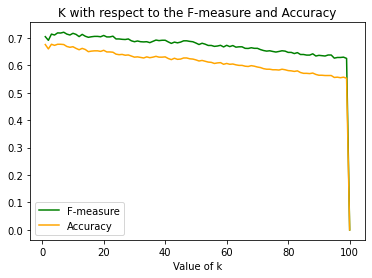

In [91]:
plt.plot(range(1, nb_k+1), f_measure[1:], c="g", label="F-measure")
plt.plot(range(1, nb_k+1), accuracy_tab[1:], c="orange", label="Accuracy")
plt.title("K with respect to the F-measure and Accuracy")
plt.xlabel("Value of k")
plt.legend()
plt.show()

### Best k

In [ ]:
best_k = np.argmax(f_measure)
print(f"The best value of k is {best_k} with an accuracy of {accuracy_tab[best_k]}")

The best value of k is 8 with an accuracy of 0.6579999999999999


We see that the accuracy is far less than the accuracy with balanced dataset

## Impact of sampling

When we have an imbalance dataset, we have 03 sampling methods : undersampling, oversampling and SMOTE.

The objective is to study the impact of the different sampling methods on the classifier

### Actual representation of the imbalance dataset

In [ ]:
from matplotlib import colors

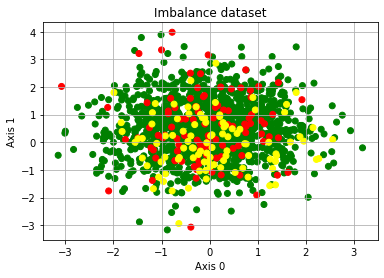

In [ ]:
plt.scatter(new_X[:, 0], new_X[:, 1], c=new_Y, cmap=colors.ListedColormap(["green", "red", "yellow"]))
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")
plt.title("Imbalance dataset")
plt.grid()
plt.show()

### Undersampling

In [ ]:
from sklearn.utils import resample

(1548, 41)
(1348, 41)
(100, 41)
(100, 41)
Data undersample :  (300, 41)


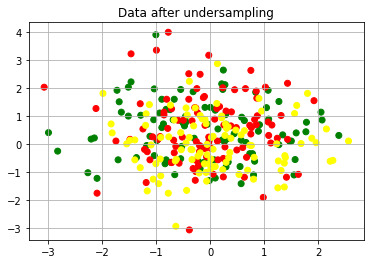

In [ ]:
data = np.hstack((new_X, new_Y))
print(data.shape)

class0 = np.where(new_Y == 0)[0]
class1 = np.where(new_Y == 1)[0]
class2 = np.where(new_Y == 2)[0]

data_class0 = data[class0]
data_class1 = data[class1]
data_class2 = data[class2]

print(data_class0.shape)
print(data_class1.shape)
print(data_class2.shape)

data_class0 = resample(data_class0, replace=False, n_samples=100, random_state=1)

data = np.vstack((data_class0, data_class1, data_class2))

print("Data undersample : ", data.shape)

x_undersample = data[:, :40].copy()
y_undersample = data[:,40].copy()

color = colors.ListedColormap(["green", "red", "yellow"])

plt.scatter(x_undersample[:,0], x_undersample[:,1], c=y_undersample, cmap=color)
plt.title("Data after undersampling")
plt.grid()
plt.show()

In [ ]:
%%timeit -r 1 -n 1
clf = knnClassifier(opt = True)
clf.fit(x_undersample, y_undersample)
score_under = clf.score(X_test, y_test)
print(f"Score : {score_under[1]}")

Score : 0.749
155 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

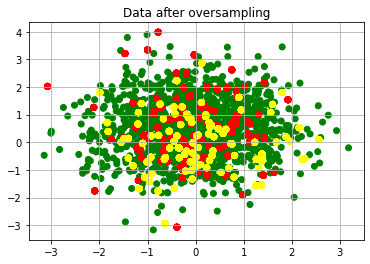

In [ ]:
ros = RandomOverSampler(random_state = 1)
x_oversample, y_oversample = ros.fit_resample(new_X, new_Y)

color = colors.ListedColormap(["green", "red", "yellow"])

plt.scatter(x_oversample[:,0], x_oversample[:,1], c=y_oversample, cmap=color)
plt.title("Data after oversampling")
plt.grid()
plt.show()

In [ ]:
print(f"Shape features after oversampling : {x_oversample.shape}")

Shape features after oversampling : (4044, 40)


In [ ]:
%%timeit -r 1 -n 1
clf = knnClassifier(opt = True)
clf.fit(x_oversample, y_oversample)
score_over = clf.score(X_test, y_test)
print(f"Score : {score_over[1]}")

Score : 0.683
1.23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

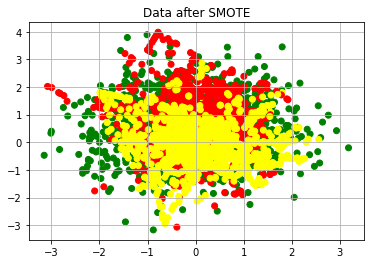

In [ ]:
sm = SMOTE(random_state = 1)
x_smote, y_smote = sm.fit_resample(new_X, new_Y)

color = colors.ListedColormap(["green", "red", "yellow"])

plt.scatter(x_smote[:,0], x_smote[:,1], c=y_smote, cmap=color)
plt.title("Data after SMOTE")
plt.grid()
plt.show()

In [ ]:
%%timeit -r 1 -n 1
clf = knnClassifier(opt = True)
clf.fit(x_smote, y_smote)
score_smote = clf.score(X_test, y_test)
print(f"Score : {score_smote[1]}")

Score : 0.749
891 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Comparison

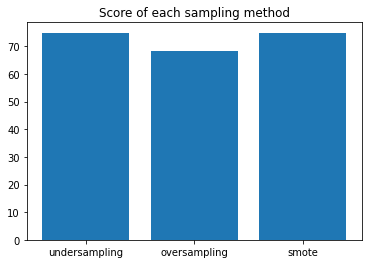

In [ ]:
plt.bar(x=[1,2,3], height=[74.9, 68.3, 74.9], tick_label=["undersampling", "oversampling", "smote"])
plt.title("Score of each sampling method")
plt.show()

Oversampling has the worst score with the lowest accuracy(68.3%) and the greatest running time(1.23 s).

SMOTE and undersampling have the same accuracy but undersampling has a better running time.

According to those results, on this dataset, in case of imbalancy, we should prefer undersampling.

## Dimensionality reduction

On this section, we're going to perform dimensionaity reduction using PCA.

Our dataset actually has 21 columns. We want to reduce its dimensionality to 3 to compare the accuracy with fewer dimensions. Hoping 03 components will be enough to represent a lot of the variance of the original data.

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [15]:
len(X_train)

4000

### PCA

In [22]:
# 1. scale the data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_train)

# 2. Perform pca
pca = PCA(n_components = 3)
pca_model = pca.fit_transform(X_scale)

columns = [f"PC{i+1}" for i in range(pca.n_components_)]

# 3. create a dataframe to visualize
df = pd.DataFrame(pca_model, columns=columns)

df.head()

,PC1,PC2,PC3
0,4.504821,-0.697085,-0.519838
1,-2.523681,1.200801,0.115844
2,1.139071,-1.611637,1.885323
3,-3.939753,-0.812368,-0.870532
4,-1.982971,-0.298010,0.239530


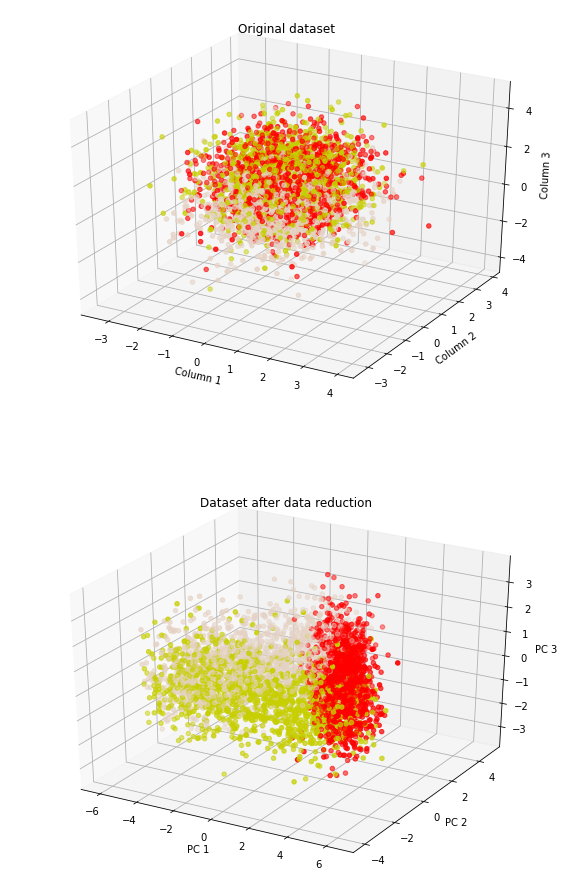

In [34]:
fig = plt.figure(figsize=(10,16))
ax1 = fig.add_subplot(211, projection="3d")
ax2 = fig.add_subplot(212, projection="3d")
cmap = colors.ListedColormap(["#c7cf00", "red", "#e5d2c4"])
ax1.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=cmap)
ax1.set_xlabel("Column 1")
ax1.set_ylabel("Column 2")
ax1.set_zlabel("Column 3")
ax1.set_title("Original dataset")

ax2.scatter(pca_model[:, 0], pca_model[:, 1], pca_model[:, 2], c=y_train, cmap=cmap)
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.set_zlabel("PC 3")
ax2.set_title("Dataset after data reduction")
plt.show()

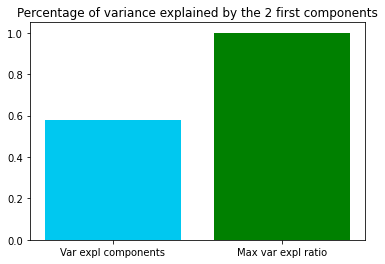

In [35]:
# let us look at the variance explained by the 2 first components
exp = np.sum(pca.explained_variance_ratio_)
plt.bar(x=[1,2], height=[exp, 1.0], 
        color=["#00c8f0", "green"], align="center",
        tick_label=["Var expl components", "Max var expl ratio"],
        )
plt.title("Percentage of variance explained by the 2 first components")
plt.show()

The 2 first components keep less than 59% of the variation in the original data. 

That's not too much but we will however use them and see if it has an impact on the accuracy

### Test of accuracy

#### Before data reduction

In [98]:
# 1. scale X_test
scaler = StandardScaler()
X_test_scale = scaler.fit_transform(X_test)

# 2. Perform PCA on test data
pca_test = pca.fit_transform(X_test_scale)

# 2. classification
knn = knnClassifier(opt = True)
knn.fit(pca_model, y_train)
accuracy_pc = knn.score(pca_test, y_test)[1]
accuracy_pc

0.313

#### After data reduction

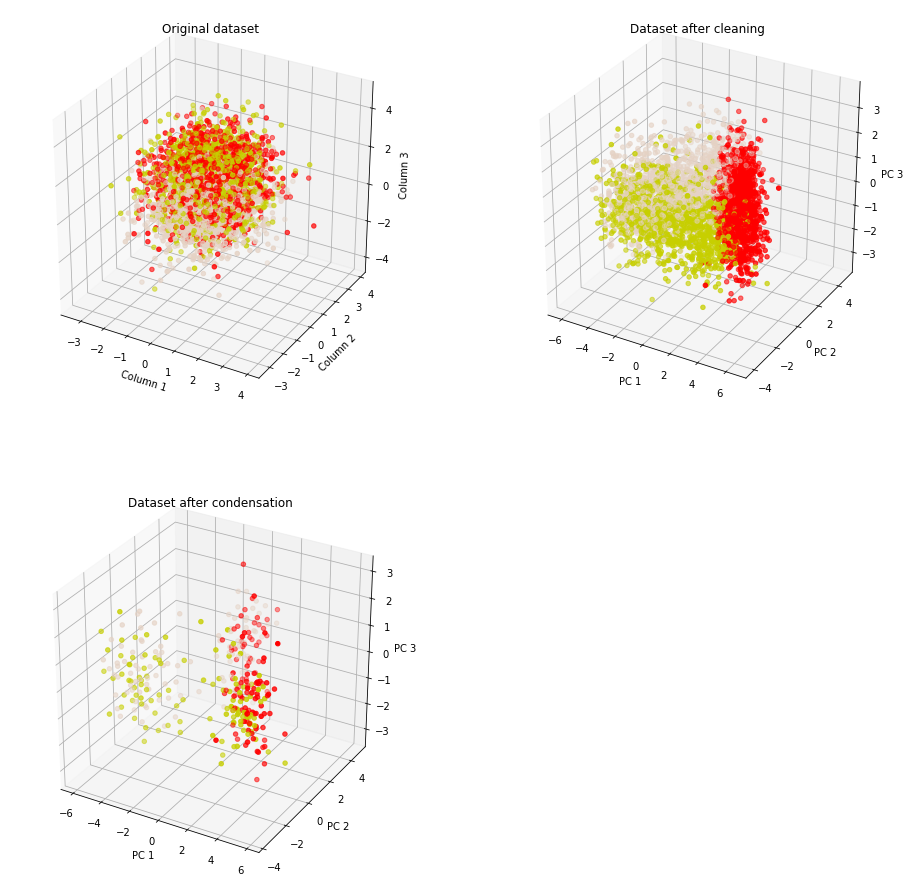

In [49]:
clf = knnClassifier(opt = True)

cmap = colors.ListedColormap(["#c7cf00", "red", "#e5d2c4"])

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221, projection="3d")
ax1.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=cmap)
ax1.set_xlabel("Column 1")
ax1.set_ylabel("Column 2")
ax1.set_zlabel("Column 3")
ax1.set_title("Original dataset")

# data cleaning
new_x_train, new_y_train = clean(pca_model, y_train)
ax2 = fig.add_subplot(222, projection="3d")
ax2.scatter(new_x_train[:, 0], new_x_train[:, 1], new_x_train[:, 2], c=new_y_train, cmap=cmap)
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.set_zlabel("PC 3")
ax2.set_title("Dataset after cleaning")

# data condensation
solution = data_condensation(new_x_train, new_y_train, clf)
x_cond = solution[0].copy()
y_cond = solution[1].copy()

ax3 = fig.add_subplot(223, projection="3d")
ax3.scatter(x_cond[:, 0], x_cond[:, 1], x_cond[:, 2], c=y_cond, cmap=cmap)
ax3.set_xlabel("PC 1")
ax3.set_ylabel("PC 2")
ax3.set_zlabel("PC 3")
ax3.set_title("Dataset after condensation")
plt.show()

In [53]:
# fit the data to the classifier
clf.fit(x_cond, y_cond)

# compute the accuracy
accuracy_pc2 = clf.score(pca_test,y_test)[1]
accuracy_pc2

0.309

#### Overall comparison

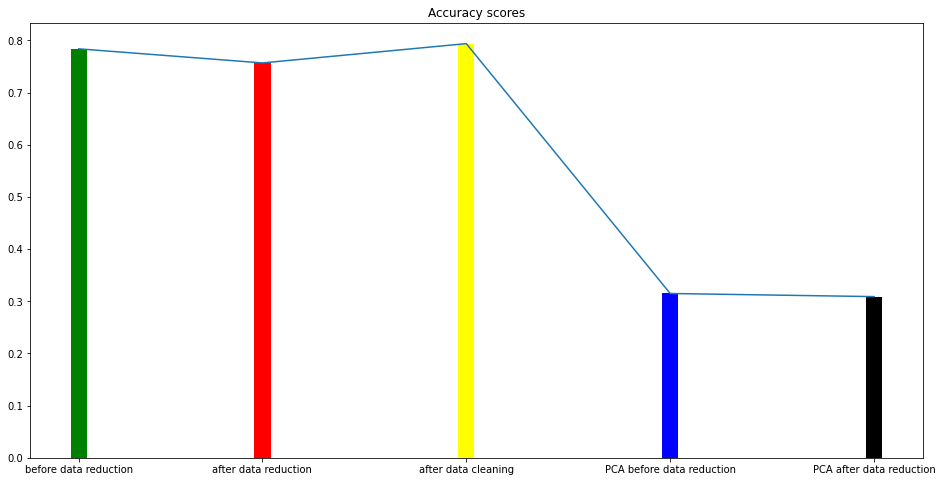

In [82]:
labs = ["before data reduction", "after data reduction", "after data cleaning",
        "PCA before data reduction", "PCA after data reduction"]
color = ["green", "red", "yellow", "blue", "black"]
plt.figure(figsize=(16, 8))
plt.bar(x=[1,10,20,30,40], height=[accuracy_bf_dr, accuracy_af_dr[1], accuracy_af_dc[1],
            accuracy_pc, accuracy_pc2], align="center", color=color, tick_label=labs
        )
plt.plot([1,10,20,30,40], [accuracy_bf_dr, accuracy_af_dr[1], accuracy_af_dc[1],
            accuracy_pc, accuracy_pc2])
plt.title("Accuracy scores")
plt.show()

The accuracies after data reduction are pretty small. 

Maybe it is because the 03 components don't keep enough information for classification.